In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Analyze the distribution of paintings per artist in the train/val dataset

Load the datasets:

In [ ]:
#I percorsi sono diversi in quanto la cartella è stata rinominata per la consegna
# [Deep Learning Project] = Pilia_De Filomeno
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
balanced_train_dir = "/content/drive/Shareddrives/[Deep Learning Project]/Dataset/balanced_train"
balanced_test_dir = "/content/drive/Shareddrives/[Deep Learning Project]/Dataset/balanced_test"

Print the number of paintings per artist in the "train" and "test" dataset:

In [ ]:
#This function is used to print the number of paintings per artist in the "train" and "test" dataset
def take_classes_size(directory):
  classes_size=[]
  classes_name=[]
  for dir in os.listdir(directory):
    dir_size=len(os.listdir(directory+"/"+dir))
    classes_size.append(dir_size)
    classes_name.append(dir)
    print(dir+": ",dir_size)
  return classes_name,classes_size

Print the number of paintings per artist in the "train" dataset:

In [ ]:
classes_name, classes_size = take_classes_size(train_dir)
print("\nTotal training paintings:", sum(classes_size))

Edgar Degas:  561
Mikhail Vrubel:  136
Rene Magritte:  155
Paul Klee:  150
Pierre-Auguste Renoir:  268
Francisco Goya:  232
Titian:  204
Albrecht Dürer:  262
Andy Warhol:  144
Henri Matisse:  148
Sandro Botticelli:  131
Alfred Sisley:  207
Amedeo Modigliani:  154
Vincent van Gogh:  701
Marc Chagall:  191
Pablo Picasso:  351
Rembrandt:  209
Paul Gauguin:  248

Total training paintings: 4452


Print the number of paintings per artist in the test dataset:

In [ ]:
test_classes_name, test_classes_size = take_classes_size(test_dir)
print("\nTotal testing paintings:", sum(test_classes_size))

Edgar Degas:  129
Mikhail Vrubel:  35
Rene Magritte:  39
Francisco Goya:  59
Pierre-Auguste Renoir:  68
Titian:  51
Albrecht Dürer:  66
Paul Klee:  38
Henri Matisse:  38
Andy Warhol:  37
Alfred Sisley:  52
Sandro Botticelli:  33
Marc Chagall:  48
Amedeo Modigliani:  39
Pablo Picasso:  88
Vincent van Gogh:  176
Paul Gauguin:  63
Rembrandt:  53

Total testing paintings: 1112


Plot the training set distribution:

<BarContainer object of 18 artists>

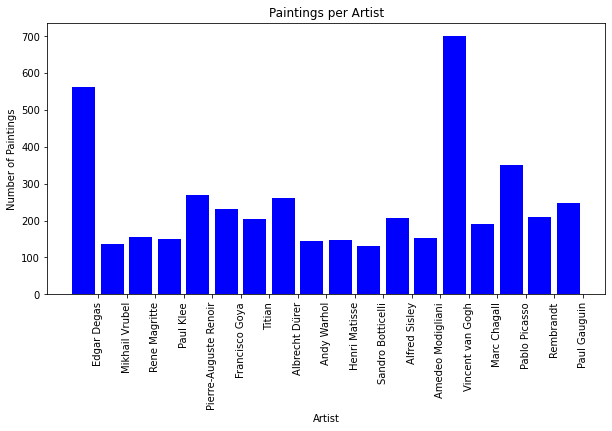

In [ ]:
plt.figure(figsize=(10,5))

artists_list= classes_name
N_paintings_list = classes_size

length = len(artists_list)

plt.xticks(np.arange(length) + .5, artists_list, rotation=90)
plt.xlabel("Artist")
plt.ylabel('Number of Paintings')
plt.title('Paintings per Artist')

plt.bar(artists_list, N_paintings_list, color='blue', label='Number of Painting by Artist')

Let's check if the dataset is unbalanced. As a rule of thumb, if the dataset has a difference (majority class - minority class) of greater than 65% to 35% is considered unbalanced.

In [ ]:
largest_class_size = max(classes_size)
smallest_class_size = min(classes_size)
difference = largest_class_size - smallest_class_size
perc_difference_with_max = difference/largest_class_size *100
perc_difference_with_min = difference/smallest_class_size *100
print("majority class size: ",largest_class_size, "\nminority class size: ",smallest_class_size, "\n-> difference: ",difference)
print("-> percentage of difference/(largest class size): ",perc_difference_with_max ,"%")

majority class size:  701 
minority class size:  131 
-> difference:  570
-> percentage of difference/(largest class size):  81.31241084165478 %


From the results obtained we can consider our dataset not balanced.

# Create new training directory for Data Augmentation

Let's create a new directory copying the train and test directories:

In [ ]:
shutil.copytree(train_dir, balanced_train_dir)
#shutil.rmtree(balanced_train_dir)

'/content/drive/Shareddrives/[Deep Learning Project]/Dataset/balanced_train'

In [ ]:
shutil.copytree(test_dir, balanced_test_dir)

'/content/drive/Shareddrives/[Deep Learning Project]/Dataset/balanced_test'

In [ ]:
drive.flush_and_unmount() #Sync with Drive

In [ ]:
#Re mount Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Print the number of samples per class in balanced train directory:

In [ ]:
classes_name, classes_size = take_classes_size(balanced_train_dir)
print("\nTotal paintings:", sum(classes_size))

Edgar Degas:  561
Mikhail Vrubel:  136
Rene Magritte:  155
Paul Klee:  150
Pierre-Auguste Renoir:  268
Francisco Goya:  232
Titian:  204
Albrecht Dürer:  262
Andy Warhol:  144
Henri Matisse:  148
Sandro Botticelli:  131
Alfred Sisley:  207
Amedeo Modigliani:  154
Vincent van Gogh:  701
Marc Chagall:  191
Pablo Picasso:  351
Rembrandt:  209
Paul Gauguin:  248

Total paintings: 4452


In [ ]:
classes_name, classes_size = take_classes_size(balanced_test_dir)
print("\nTotal paintings:", sum(classes_size))

Rene Magritte:  39
Edgar Degas:  240
Mikhail Vrubel:  35
Titian:  51
Albrecht Dürer:  66
Francisco Goya:  59
Andy Warhol:  37
Henri Matisse:  38
Paul Klee:  38
Pierre-Auguste Renoir:  68
Alfred Sisley:  52
Sandro Botticelli:  33
Marc Chagall:  48
Vincent van Gogh:  427
Amedeo Modigliani:  39
Pablo Picasso:  88
Paul Gauguin:  63
Rembrandt:  53

Total paintings: 1474


# Data Augmentation for minority classes

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.1), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.2) # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

Plot an example:

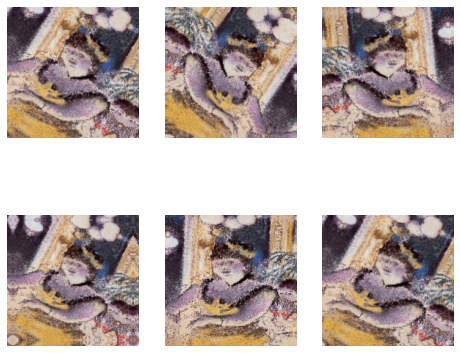

In [ ]:
IMAGE_HEIGHT =IMAGE_WIDTH= 180

for artist_name in os.listdir(train_dir):
  for image_name in os.listdir(train_dir+"/"+artist_name):

    img = tf.keras.utils.load_img(train_dir+"/"+artist_name+"/"+image_name, 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

    img_array = tf.keras.utils.img_to_array(img)
    # plt.imshow(img_array.astype("uint8"))

    plt.figure(figsize=(8, 7))
    for i in range(6):
      augmented_image = data_augmentation(img_array)
      ax = plt.subplot(2, 3, i + 1)
      plt.imshow(augmented_image.numpy().astype("uint8"))
      plt.axis("off")
    break
  break

Let's use Data Augmentation to increase minority classes in order to have at least 450 paintings per artist:

In [ ]:
from ast import Break
import matplotlib.image as mpimg

#Number of minimum number of samples that we want for each class
min_number_of_samples=450

for artist_name in os.listdir(balanced_train_dir):

  #counter to keep track of the number of images that must be added to a class
  n_images_added_counter=0
  artist_listdir=os.listdir(balanced_train_dir+"/"+artist_name)

  #if we don't have enough samples
  if(len(artist_listdir)<min_number_of_samples):

    n_samples_to_be_added = min_number_of_samples-len(artist_listdir)

    #Until we reach n_images_added_counter samples
    while ((len(artist_listdir) + n_images_added_counter) < min_number_of_samples):
      
      #Access sequentially one image at a time
      for image_name in os.listdir(train_dir+"/"+artist_name):
          if(n_images_added_counter >= n_samples_to_be_added):
                break
          
          #Load the image
          img = tf.keras.utils.load_img(train_dir+"/"+artist_name+"/"+image_name, 
                                        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
          
          #Cast, create an augmented image based on the current image and add it to the class folder
          img_array = tf.keras.utils.img_to_array(img)
          augmented_image = data_augmentation(img_array) #create a single augmented image
          tf.keras.utils.save_img(balanced_train_dir+'/'+artist_name+'/'+str(n_images_added_counter)+'_augm.jpg', augmented_image)

          n_images_added_counter+=1

In [ ]:
classes_name, classes_size = take_classes_size(balanced_train_dir)

Edgar Degas:  450
Mikhail Vrubel:  450
Rene Magritte:  450
Paul Klee:  450
Pierre-Auguste Renoir:  450
Francisco Goya:  450
Titian:  450
Albrecht Dürer:  450
Andy Warhol:  450
Henri Matisse:  450
Sandro Botticelli:  450
Alfred Sisley:  450
Amedeo Modigliani:  450
Vincent van Gogh:  450
Marc Chagall:  450
Pablo Picasso:  450
Rembrandt:  450
Paul Gauguin:  450


Plot the new class distribution:

<BarContainer object of 18 artists>

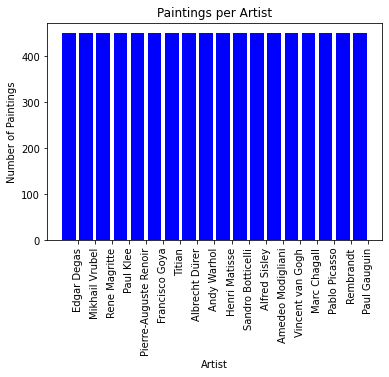

In [ ]:
artists_list= classes_name
N_paintings_list = classes_size

length = len(artists_list)

plt.xticks(np.arange(length) + .5, artists_list, rotation=90)
plt.xlabel("Artist")
plt.ylabel('Number of Paintings')
plt.title('Paintings per Artist')

plt.bar(artists_list, N_paintings_list, color='blue', label='Number of Painting by Artist')

# Reduce samples from majority classes 

In [ ]:
classes_name, classes_size = take_classes_size(balanced_train_dir)
print("\nTotal paintings:", sum(classes_size))

Edgar Degas:  561
Mikhail Vrubel:  450
Rene Magritte:  450
Paul Klee:  450
Pierre-Auguste Renoir:  450
Francisco Goya:  450
Titian:  450
Albrecht Dürer:  450
Andy Warhol:  450
Henri Matisse:  450
Sandro Botticelli:  450
Alfred Sisley:  450
Amedeo Modigliani:  450
Vincent van Gogh:  701
Marc Chagall:  450
Pablo Picasso:  450
Rembrandt:  450
Paul Gauguin:  450

Total paintings: 8462


In [ ]:
max_number_of_samples=450


for artist_name in os.listdir(balanced_train_dir):
  count=0
  artist_listdir=os.listdir(balanced_train_dir+"/"+artist_name)

  #If the samples of the class is greather than the number of samples that we want
  if(len(artist_listdir)>max_number_of_samples):
    n_samples_to_be_removed=len(artist_listdir)-max_number_of_samples

    #Remove the exceeding samples from the class
    for image_name in os.listdir(balanced_train_dir+"/"+artist_name):
          if(count>=n_samples_to_be_removed):
            break
          #shutil.move(balanced_train_dir+"/"+artist_name+"/"+image_name, balanced_test_dir+"/"+artist_name+"/"+image_name)
          os.remove(balanced_train_dir+"/"+artist_name+"/"+image_name)  
          count+=1

In [ ]:
classes_name, classes_size = take_classes_size(balanced_test_dir)
print("\nTotal paintings:", sum(classes_size))

Rene Magritte:  39
Edgar Degas:  240
Mikhail Vrubel:  35
Titian:  51
Albrecht Dürer:  66
Francisco Goya:  59
Andy Warhol:  37
Henri Matisse:  38
Paul Klee:  38
Pierre-Auguste Renoir:  68
Alfred Sisley:  52
Sandro Botticelli:  33
Marc Chagall:  48
Vincent van Gogh:  427
Amedeo Modigliani:  39
Pablo Picasso:  88
Paul Gauguin:  63
Rembrandt:  53

Total paintings: 1474


In [ ]:
classes_name, classes_size = take_classes_size(balanced_train_dir)
print("\nTotal paintings:", sum(classes_size))

Edgar Degas:  450
Mikhail Vrubel:  450
Rene Magritte:  450
Paul Klee:  450
Pierre-Auguste Renoir:  450
Francisco Goya:  450
Titian:  450
Albrecht Dürer:  450
Andy Warhol:  450
Henri Matisse:  450
Sandro Botticelli:  450
Alfred Sisley:  450
Amedeo Modigliani:  450
Vincent van Gogh:  450
Marc Chagall:  450
Pablo Picasso:  450
Rembrandt:  450
Paul Gauguin:  450

Total paintings: 8100


<BarContainer object of 18 artists>

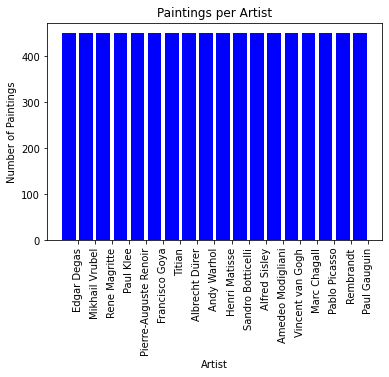

In [ ]:
artists_list= classes_name
N_paintings_list = classes_size

length = len(artists_list)

plt.xticks(np.arange(length) + .5, artists_list, rotation=90)
plt.xlabel("Artist")
plt.ylabel('Number of Paintings')
plt.title('Paintings per Artist')

plt.bar(artists_list, N_paintings_list, color='blue', label='Number of Painting by Artist')

# Compute new test set size:

In [ ]:
drive.flush_and_unmount()

In [ ]:
#Re mount Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
test_classes_name, test_classes_size = take_classes_size(balanced_test_dir)
print("\nTotal testing paintings:", sum(test_classes_size))

Rene Magritte:  39
Edgar Degas:  240
Mikhail Vrubel:  35
Titian:  51
Albrecht Dürer:  66
Francisco Goya:  59
Andy Warhol:  37
Henri Matisse:  38
Paul Klee:  38
Pierre-Auguste Renoir:  68
Alfred Sisley:  52
Sandro Botticelli:  33
Marc Chagall:  48
Vincent van Gogh:  427
Amedeo Modigliani:  39
Pablo Picasso:  88
Paul Gauguin:  63
Rembrandt:  53

Total testing paintings: 1474


In [ ]:
classes_name, classes_size = take_classes_size(balanced_train_dir)
print("\nTotal paintings:", sum(classes_size))

Edgar Degas:  450
Mikhail Vrubel:  450
Rene Magritte:  450
Paul Klee:  450
Pierre-Auguste Renoir:  450
Francisco Goya:  450
Titian:  450
Albrecht Dürer:  450
Andy Warhol:  450
Henri Matisse:  450
Sandro Botticelli:  450
Alfred Sisley:  450
Amedeo Modigliani:  450
Vincent van Gogh:  450
Marc Chagall:  450
Pablo Picasso:  450
Rembrandt:  450
Paul Gauguin:  450

Total paintings: 8100
